In [54]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from keras import models
from keras import layers
import matplotlib.pyplot as plt

Verover de data. Het is een dataset van IMDB met filmrecensies. De labels zijn binair en geven aan of een film wel of geen aanrader is volgens de reviews.

In [55]:
from keras.datasets import imdb

(X_train, y_train), (X_test, y_test) = imdb.load_data(path="imdb.npz", num_words=10000,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      seed=42,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

bekijk de geimporteerde data.

In [56]:
print(X_train)

[list([1, 11, 4079, 11, 4, 1986, 745, 3304, 299, 1206, 590, 3029, 1042, 37, 47, 27, 1269, 2, 7637, 19, 6, 3586, 15, 1367, 3196, 17, 1002, 723, 1768, 2887, 757, 46, 4, 232, 1131, 39, 107, 3589, 11, 4, 4539, 198, 24, 4, 1834, 133, 4, 107, 7, 98, 413, 8911, 5835, 11, 35, 781, 8, 169, 4, 2179, 5, 259, 334, 3773, 8, 4, 3497, 10, 10, 17, 16, 3381, 46, 34, 101, 612, 7, 84, 18, 49, 282, 167, 2, 7173, 122, 24, 1414, 8, 177, 4, 392, 531, 19, 259, 15, 934, 40, 507, 39, 2, 260, 77, 8, 162, 5097, 121, 4, 65, 304, 273, 13, 70, 1276, 2, 8, 15, 745, 3304, 5, 27, 322, 2197, 2, 2, 70, 30, 2, 88, 17, 6, 3029, 1042, 29, 100, 30, 4943, 50, 21, 18, 148, 15, 26, 5980, 12, 152, 157, 10, 10, 21, 19, 3196, 46, 50, 5, 4, 1636, 112, 828, 6, 1003, 4, 162, 5097, 2, 517, 6, 2, 7, 4, 9527, 5593, 4, 351, 232, 385, 125, 6, 1693, 39, 2383, 5, 29, 69, 5593, 5670, 6, 162, 5097, 1567, 232, 256, 34, 718, 5612, 2980, 8, 6, 226, 762, 7, 2, 7830, 5, 517, 2, 6, 3242, 7, 4, 351, 232, 37, 9, 1861, 8, 123, 3196, 2, 5612, 188, 5165

Zoals je kunt zien bevat `X_train` vectoren met getallen. Elke vector staat voor een review. Elk getal staat voor een woord.

Met onderstaande code kun je een vector met getallen terugvertalen naar woorden. Run deze code.

In [57]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in X_train[0]])
decoded_review

"? in panic in the streets richard widmark plays u s navy doctor who has his week ? interrupted with a corpse that contains plague as cop paul douglas properly points out the guy died from two bullets in the chest that's not the issue here the two of them become unwilling partners in an effort to find the killers and anyone else exposed to the disease br br as was pointed out by any number of people for some reason director ? kazan did not bother to cast the small parts with anyone that sounds like they're from ? having been to new orleans where the story takes place i can personally ? to that richard widmark and his wife barbara ? ? can be ? because as a navy doctor he could be assigned there but for those that are natives it doesn't work br br but with plague out there and the news being kept a secret the new orleans ? starts a ? of the city's underworld the dead guy came off a ship from europe and he had underworld connections a new orleans wise guy played by jack palance jumps to a

In de tekst zie je een aantal vraagtekens. Een vraagteken staat in dit geval voor 'onbekend woord'.

De input is in deze vorm lastig te verwerken voor een neuraal netwerk. De getallen zijn categorische labels. Daarom gebruiken we One-hot-encoding. Helaas kan de `OneHotEncoder` uit sklearn niet overweg met deze input. Daarom maken we de input handmatig geschikt voor het neurale netwerk.

In [58]:
def vectorize_sequences(sequences, dimension=10000):
    # Maak een matrix van de vorm (len(sequences), dimension) met nullen
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # zet de juiste waarden in results[i] op 1
    return results

In [59]:
X_train = vectorize_sequences(X_train)
X_test = vectorize_sequences(X_test)

y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

Controleer of het omzetten van de data goed gegaan is

In [60]:
print(y_train[0:100])

[1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0.
 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0.
 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 1. 1. 0. 0.]


Maak een neuraal netwerk dat met deze data overweg kan.

In [61]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()

model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


Kies een loss function en optimizer en compileer het netwerk. Bedenk hierbij goed welke het meest geschikt is voor het probleem dat je aan het oplossen bent en voor de vorm van de output.

In [62]:
from tensorflow.keras.optimizers import Adam

model.compile(Adam(learning_rate=0.01),'categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 16)                160016    
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


Split in train en validatieset

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42)

In [64]:
X_train[0:10]

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [65]:
y_train[0:10]

array([0., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

Train je model model met de gemaakte train- en validatieset. 

In [ ]:
verloop = model.fit(X_train, y_train,
                    epochs = 3,
                    batch_size = 10,
                    validation_data = (X_val, y_val))

Plot een learning curve. Zet de accuraatheid uit tegen de epochs en maak onderscheid tussen de training en validatie data. Wat zou volgens dit figuur het optimale aantal epochs zijn?

In [67]:
history_dict = verloop.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [71]:
acc = verloop.history['accuracy']
val_acc = verloop.history['val_accuracy']
loss = verloop.history['loss']
val_loss = verloop.history['val_loss']

epochs = range(1, len(acc) + 1)

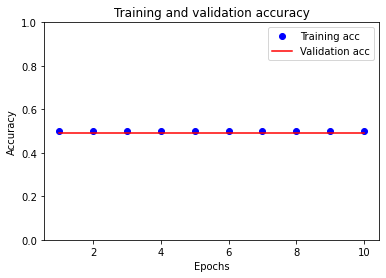

In [72]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'red')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend()

plt.show()

Plot een foutcurve. Zet de loss uit tegen de epochs en maak onderscheid tussen de training en validatie data. Bekijk of er misschien sprake is van overfitting/underfitting.

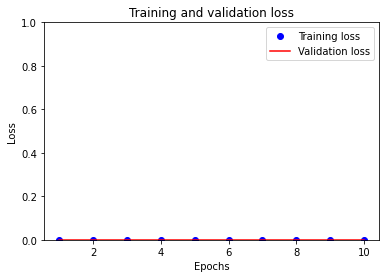

In [73]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'red')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.legend()

plt.show()

Test je model

In [74]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(test_acc)

782/782 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 0.5000
0.5


Kijk wat er gebeurt met de foutcurves van de train en validatiedata en met de testscore als je verschillende netwerken maakt met verschillende instellingen (aantal lagen, aantal neuronen, optimizer).

In [75]:
model = models.Sequential()

model.add(layers.Dense(256, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer = 'rmsprop',
              metrics = ['accuracy'],
             loss = 'binary_crossentropy')

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 256)               2560256   
_________________________________________________________________
dense_16 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_17 (Dense)             (None, 16)                2064      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 17        
Total params: 2,595,233
Trainable params: 2,595,233
Non-trainable params: 0
_________________________________________________________________


In [76]:
verloop = model.fit(X_train, y_train,
                    epochs = 5,
                    batch_size = 5,
                    validation_data = (X_val, y_val))

Epoch 1/5
4500/4500 [==============================] - 90s 20ms/step - loss: 0.3424 - accuracy: 0.8640 - val_loss: 0.3306 - val_accuracy: 0.8880
Epoch 2/5
4500/4500 [==============================] - 73s 16ms/step - loss: 0.2687 - accuracy: 0.9088 - val_loss: 0.2780 - val_accuracy: 0.8920
Epoch 3/5
4500/4500 [==============================] - 75s 17ms/step - loss: 0.2413 - accuracy: 0.9218 - val_loss: 0.3439 - val_accuracy: 0.8912
Epoch 4/5
4500/4500 [==============================] - 82s 18ms/step - loss: 0.2328 - accuracy: 0.9297 - val_loss: 0.3548 - val_accuracy: 0.8892
Epoch 5/5
4500/4500 [==============================] - 85s 19ms/step - loss: 0.2180 - accuracy: 0.9379 - val_loss: 0.2978 - val_accuracy: 0.8836


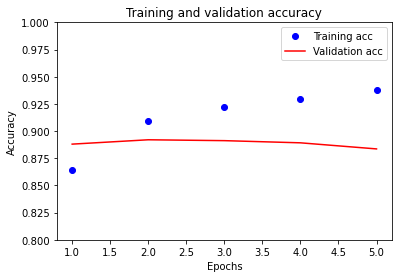

In [78]:
acc = verloop.history['accuracy']
val_acc = verloop.history['val_accuracy']
loss = verloop.history['loss']
val_loss = verloop.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'red')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.8,1)
plt.legend()

plt.show()